In [1]:
import itertools

PARAM_GRID = {
    "temperature": [0.3, 0.7, 1.0],
    "top_p": [0.8, 0.9, 1.0],
    "frequency_penalty": [0.0, 0.5],
    "presence_penalty": [0.0, 0.5],
    "max_tokens": [300, 500],
}


In [2]:
def get_param_variants(param_grid):
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    for combo in itertools.product(*values):
        yield dict(zip(keys, combo))


In [3]:
BASE_PROMPT = "Describe a futuristic city where humans and AI coexist."


In [4]:
# "# Get the current notebook's directory\n",
#     "notebook_dir = os.getcwd()\n",
#     "# Get the parent directory of 'agentic_story' which is where 'script.py' is located\n",
#     "parent_dir = os.path.abspath(os.path.join(notebook_dir, '..', '..'))\n",
#     "\n",
#     "# Add the parent directory to sys.path if it's not already there\n",
#     "if parent_dir not in sys.path:\n",
#     "    sys.path.insert(0, parent_dir)\n",
#     "\n",
#     "# Now you can import from script.py\n",
#     "from script import my_utility_function\n",

import sys
import os

# Get the current notebook's directory
notebook_dir = os.getcwd()
# Get the parent directory of 'agentic_story' which is where 'script.py' is located
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..', '..'))

# Add the parent directory to sys.path if it's not already there
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from script import send_message

def run_test_case(prompt, params):
    messages = [
        {"role": "user", "content": prompt}
    ]
    return send_message(messages, **params)


In [5]:
import os
import hashlib
import json

OUTPUT_DIR = "analysis_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_output(prompt, params, output):
    tag = hashlib.md5(json.dumps(params, sort_keys=True).encode()).hexdigest()[:8]
    filename = f"gen_{tag}.txt"
    with open(os.path.join(OUTPUT_DIR, filename), "w") as f:
        f.write("Params:\n")
        f.write(json.dumps(params, indent=2))
        f.write("\n\nOutput:\n")
        f.write(output)


In [6]:
def run_all_tests():
    for param_set in get_param_variants(PARAM_GRID):
        print(f"\n[Testing] {param_set}")
        try:
            output = run_test_case(BASE_PROMPT, param_set)
            save_output(BASE_PROMPT, param_set, output)
        except Exception as e:
            print(f"[Error] Failed for params {param_set}: {e}")


In [7]:
if __name__ == "__main__":
    run_all_tests()



[Testing] {'temperature': 0.3, 'top_p': 0.8, 'frequency_penalty': 0.0, 'presence_penalty': 0.0, 'max_tokens': 300}

Welcome to Neo-Elysium, a futuristic city that embodies the perfect blend of human ingenuity and artificial intelligence. This metropolis is a marvel of modern architecture, innovation, and progress, where humans and AI live in harmony.

**The Cityscape**

Neo-Elysium sprawls across a vast expanse of land, with towering skyscrapers that pierce the sky like crystal shards. The city's skyline is dominated by the iconic Spire of Eternity, a 100-story tower that serves as both a hub for AI operations and a beacon of hope for humanity. The city's infrastructure is designed to be sustainable, efficient, and adaptive, with self-healing roads, energy-harvesting buildings, and advanced water management systems.

**Human Settlements**

Humans live in various districts, each with its unique character and atmosphere. The Residential Arcades offer luxurious living quarters, complete 

In [9]:
import os
import json
import pandas as pd

def load_results_from_txt(folder="analysis_outputs"):
    records = []

    for fname in os.listdir(folder):
        if not fname.endswith(".txt"):
            continue
        with open(os.path.join(folder, fname), "r", encoding="utf-8") as f:
            lines = f.readlines()

        # Parse parameters
        param_start = lines.index("Params:\n") + 1
        output_start = lines.index("Output:\n")
        param_block = "".join(lines[param_start:output_start]).strip()
        output_text = "".join(lines[output_start + 1:]).strip()

        try:
            params = json.loads(param_block)
        except json.JSONDecodeError:
            continue  # skip broken files

        params["output_length"] = len(output_text.split())
        params["output"] = output_text
        records.append(params)

    return pd.DataFrame(records)

df = load_results_from_txt("analysis_outputs")


In [14]:
df.to_csv("pre_analysis_results.csv", index=False)


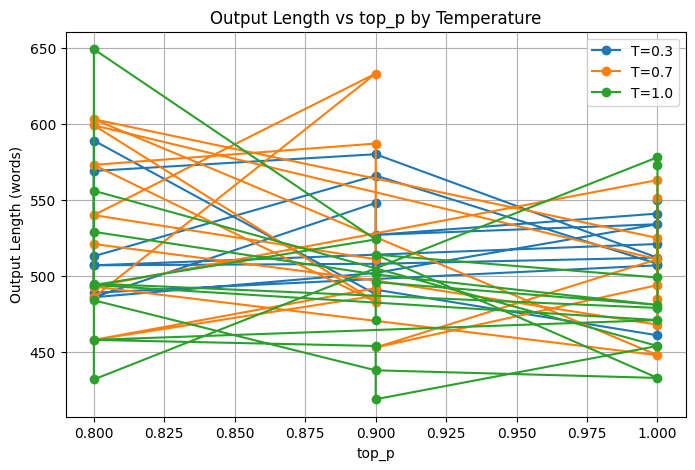

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for t in sorted(df["temperature"].unique()):
    subset = df[df["temperature"] == t]
    plt.plot(subset["top_p"], subset["output_length"], marker='o', label=f"T={t}")

plt.title("Output Length vs top_p by Temperature")
plt.xlabel("top_p")
plt.ylabel("Output Length (words)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
def lexical_diversity(text):
    words = text.lower().split()
    if not words:
        return 0
    return len(set(words)) / len(words)

df["lexical_diversity"] = df["output"].apply(lexical_diversity)


In [ ]:
from textblob import TextBlob

def sentiment_score(text):
    return TextBlob(text).sentiment.polarity  # Range: -1 (neg) to 1 (pos)

df["sentiment"] = df["output"].apply(sentiment_score)


In [ ]:
from collections import Counter

def repetition_score(text):
    words = text.lower().split()
    word_counts = Counter(words)
    repeated = [count for word, count in word_counts.items() if count > 1]
    return sum(repeated) / len(words) if words else 0

df["repetition"] = df["output"].apply(repetition_score)


In [ ]:
import textstat

df["readability"] = df["output"].apply(textstat.flesch_reading_ease)


In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["output"].tolist(), convert_to_tensor=True)

# Pairwise cosine similarity matrix
similarity_matrix = util.pytorch_cos_sim(embeddings, embeddings).numpy()

# Average similarity to all others
df["avg_similarity"] = similarity_matrix.mean(axis=1)


In [ ]:
plt.figure(figsize=(8, 5))
for freq in sorted(df["frequency_penalty"].unique()):
    subset = df[df["frequency_penalty"] == freq]
    plt.plot(subset["temperature"], subset["repetition"], marker='o', label=f"Freq={freq}")

plt.title("Repetition vs Temperature (grouped by frequency_penalty)")
plt.xlabel("Temperature")
plt.ylabel("Repetition Score")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df.to_csv("final_analysis_results.csv", index=False)
